In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import filters

from opm import make_opm, plot_opm, plot_amplitude_map, get_indices
from pinwheels import plot_pinwheels
from response import response, create_stimuli, compute_responses
from kernels import mexican_hat_kernel

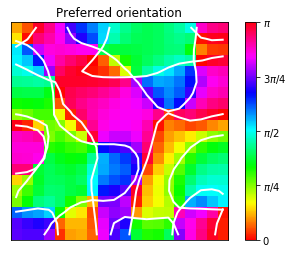

In [2]:
size = 20

n = size**2
d = 3

# ground truth opm
m = make_opm(size=size, sigma=2., k=2.)

f, ax = plot_opm(m)
plot_pinwheels(m, ax)

plt.show()

idx = get_indices(size)

In [3]:
# compute responses
contrasts = [0.25, 0.5, 1.0]
orientations = [i * np.pi / 8 - np.pi/2 for i in range(8)]
repetitions = 8

V = create_stimuli(contrasts, orientations, repetitions)
R = compute_responses(m, contrasts, orientations, repetitions)

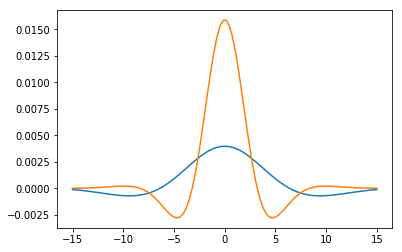

In [4]:
xx = np.linspace(-15, 15, 100)[:,np.newaxis]
plt.plot(xx, mexican_hat_kernel(0, xx, sigma=3., k=2.))
plt.plot(xx, mexican_hat_kernel(0, xx, sigma=3., k=0.5))
plt.show()

In [5]:
def K_prior(idx, kernel, **kwargs):
    """ Compute the prior covariance matrix for an OPM, given a kernel function
    Args:
        idx: The indices at which to compute the covariance (npixels x 2 matrix, where the kth column contains the x and y coordinates of the kth pixel)
        kernel: a kernel function that takes two vectors x and y
        kwargs: parameters for the kernel function
    """
    
    K = np.zeros((idx.shape[0], idx.shape[0]))
    for i in range(idx.shape[0]):
        for j in range(idx.shape[0]):
            K[i, j] = kernel(idx[[i]], idx[[j]], **kwargs)
            
    return K

In [6]:
K = K_prior(idx, kernel=mexican_hat_kernel, sigma=2.)

K_m = np.kron(np.eye(d), K)

In [7]:
# assume that the noise covariance is know (iid Gaussian noise)
sigma_e = 0.1
K_e = np.eye(n) * sigma_e

In [8]:
# posterior covariance
K_post = np.linalg.inv(np.linalg.inv(K_m) + np.kron(V.T @ V, K_e))

In [9]:

vr = np.zeros((n*d,1))
for v, r in zip(V, R):
    vr += np.kron(v, r)[:,np.newaxis]
    
mu_post = K_post @ np.kron(np.eye(d), np.linalg.inv(K_e)) @ vr

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbe68f54b70>)

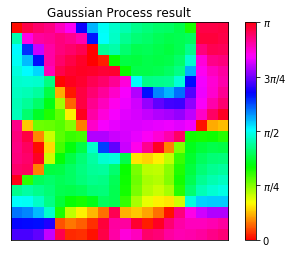

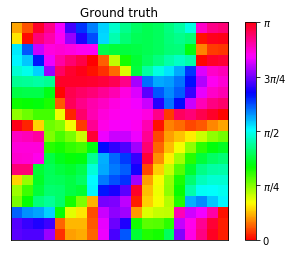

In [10]:
mu = mu_post.reshape(d, size, size)
result = mu[0] + 1j * mu[1]
plot_opm(result, title='Gaussian Process result')

plot_opm(m, title='Ground truth')